### Import libraries

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Create common functions
Simple functions that will be used frequently

In [11]:
# Open csv
def open_csv(fname):
    df = pd.read_csv('../csv/' + fname)
    return df

# Save csv
def save_csv(fname):
    pd.to_csv('../csv/' + fname)

### Import data and perform basic exploration
There are three main data:
* DA1920_store.csv
    * Contains supplementary information of 1,115 drug stores.
    
    ![store_description](../img/store_description.png)

* DA1920_train.csv
    * Contains the historical sales data from 01/01/2013 to 31/07/2015

    ![train_description](../img/train_description.png)
    
* DA1920_test.csv
    * Identical to train but without sales and customers data.

The goal is to use the train data to build predictive models and forecast the sales of the test data.

In [12]:
store = open_csv('DA1920_store.csv')
train = open_csv('DA1920_train.csv')
test = open_csv('DA1920_test.csv')

In [13]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
 10  Unnamed: 10                0 non-null      float64
 11  Unnamed: 11                1 non-null      object 
dtypes: float64(6), int64(2), object(4)
memory usage: 104.7+ KB


In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [15]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Store          41088 non-null  int64  
 1   DayOfWeek      41088 non-null  int64  
 2   Date           41088 non-null  object 
 3   Sales          0 non-null      float64
 4   Customers      0 non-null      float64
 5   Open           41077 non-null  float64
 6   Promo          41088 non-null  int64  
 7   StateHoliday   41088 non-null  object 
 8   SchoolHoliday  41088 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 2.8+ MB


The `store` data contains several flaws:
* `CompetitionDistance`, `CompetitionOpenSinceMonth`, `CompetitionOpenSinceYear`, `Promo2SinceWeek`, `Promo2SinceYear`, and `PromoInterval` contains missing data.
* The last two empty columns are useless.

Similarly, `test` data also contains missing data for `Open`; whereas `train` data does not have any missing data.

We can also perform some visualizations to obtain addition details of the data before proceeding to further steps.

In [16]:
train_copy = train.copy()
train_copy['Date'] = pd.to_datetime(train_copy['Date'], infer_datetime_format = True)
train_copy_storecount = pd.DataFrame(train_copy.groupby('Date')['Store'].count()).reset_index()

Set `infer_datetime_format=True` to enable pandas take more accurate guess of the date because current data type for `Date` is string. Without setting this as `True`, the date will mess up. E.g. `2015-07-12` will become `2015-12-07`, while the dataset only consist data up to `2015-07-31`.

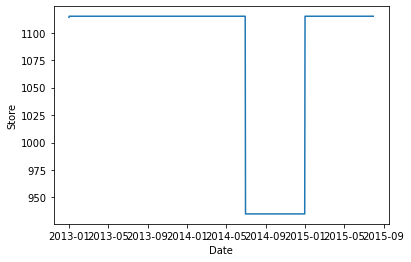

In [134]:
fig, ax = plt.subplots(figsize=(6,4))
sns.lineplot(x='Date', y='Store', data=train_copy_storecount, ax=ax)

Given `train` dataset has sales data of 1,115 stores for 942 days, it is expected that it contains 1,050,330 observations. However, results from `train.info()` shows there're only 1,017,209 data available. Investigation reveals a six-month gap of missing sales data for 180 stores.

Text(0.5, 1.0, 'Sales Gap for Store 20')

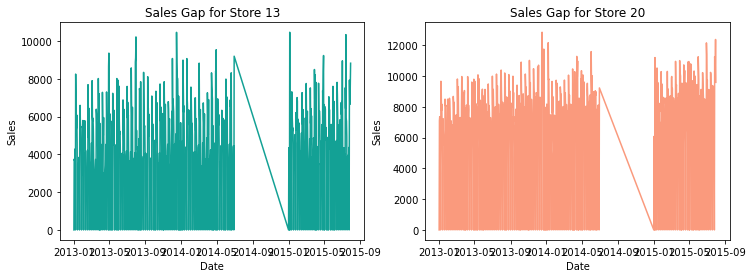

In [135]:
train_copy_store13 = train_copy[train_copy['Store'] == 13]
train_copy_store20 = train_copy[train_copy['Store'] == 20]
fig, ax = plt.subplots(1, 2, figsize=(12,4))
sns.lineplot(x='Date', y='Sales', data=train_copy_store13, ax=ax[0], color='#13A195')
ax[0].set_title('Sales Gap for Store 13')
sns.lineplot(x='Date', y='Sales', data=train_copy_store20, ax=ax[1], color='#FA9A7D')
ax[1].set_title('Sales Gap for Store 20')

Some stores do not have sales data from `2014-06-30` to `2015-01-01`. No information were provided to explain the existence of this gap, but it is presumed that these stores were closed temporarily for that period due to extensive renovations or repairs lasting six months.

Let's perform some missing data analysis.

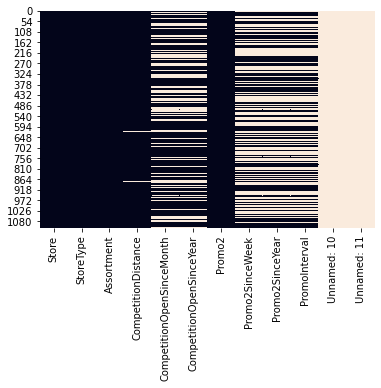

In [20]:
fig, ax = plt.subplots()
sns.heatmap(store.isnull(), cbar=False, ax=ax)

Missing data matrix is very useful to observe at which record the data are missing. Blue color indicates data is available, whereas beige color means there's missing data. More beige color means more missing data (see last two columns). <br>

Visualization package for missing data analysis in Python is rather scarce. Hence, some analysis was conducted in R to generate more interesting plots.

![store_missing](../img/store_missing.png)

Visualize the number of missing data of each variable using `ggplot2`.

![promotion_missing](../img/promo_missing.png)

Visualize the missing data in `Promo2SinceYear`, `Promo2SinceWeek`, and `PromoInterval` across different store types. The density plots reveals majority of stores under type B do not have continuous promotions.

Text(0.5, 1.0, 'PromoInterval')

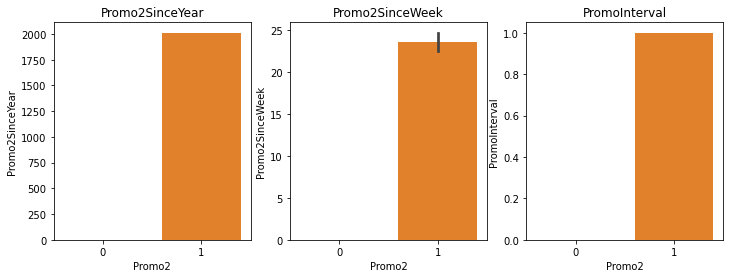

In [131]:
store_copy = store.copy()
store_copy['PromoInterval'] = store_copy['PromoInterval'].apply(lambda x: np.NaN if x is np.NaN else 1)
fig, ax = plt.subplots(1,3, figsize=(12,4))
sns.barplot(x='Promo2', y='Promo2SinceYear', data=store,ax=ax[0])
ax[0].set_title('Promo2SinceYear')
sns.barplot(x='Promo2', y='Promo2SinceWeek', data=store,ax=ax[1])
ax[1].set_title('Promo2SinceWeek')
sns.barplot(x='Promo2', y='PromoInterval', data=store_copy,ax=ax[2])
ax[2].set_title('PromoInterval')

The barplot above shows if a store contains 0 in `Promo2` then it is observed with `NA` in `Promo2SinceYear`, `Promo2SinceWeek`, and `PromoInterval`.

<img src = '../img/competition_missing.png' width=50% height=50%/>
`NA` observed in `CompetitionOpenSinceYear` was found to correspond with `NA` in `CompetitionOpenSinceMonth`.